In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [76]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-03 20:20:17,945 INFO: Closing external client and cleaning up certificates.


Connection closed.
2025-03-03 20:20:17,961 INFO: Initializing external client
2025-03-03 20:20:17,962 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 20:20:18,603 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215642


In [77]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1215642/fs/1202294/fv/time_series_hourly_feature_view/version/1
Feature view 'time_series_hourly_feature_view' (version 1) created successfully.
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [78]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.10s) 


In [79]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [80]:
ts_data.tail()

,pickup_hour,pickup_location_id,rides
2309612,2024-01-01 00:00:00+00:00,263,188
2309613,2024-01-01 01:00:00+00:00,263,198
2309614,2024-01-01 02:00:00+00:00,263,232
2309615,2024-01-01 03:00:00+00:00,263,160
2309616,2024-01-01 04:00:00+00:00,263,95


In [81]:
ts_data["pickup_hour"].min()

'2023-01-01 05:00:00+00:00'

In [82]:
ts_data["pickup_hour"].max()

'2025-03-04 00:00:00+00:00'

In [83]:
ts_data_copy = ts_data.copy()

In [84]:
ts_data = ts_data_copy

In [85]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [86]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309617 entries, 0 to 2309616
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 35.2 MB


In [87]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [88]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309617 entries, 0 to 2309616
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 35.2 MB


In [89]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [90]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 05:00:00,2,0,2023-01
1,2023-01-01 06:00:00,2,0,2023-01
2,2023-01-01 07:00:00,2,0,2023-01
3,2023-01-01 08:00:00,2,0,2023-01
4,2023-01-01 09:00:00,2,0,2023-01
...,...,...,...,...
2309612,2024-01-01 00:00:00,263,188,2024-01
2309613,2024-01-01 01:00:00,263,198,2024-01
2309614,2024-01-01 02:00:00,263,232,2024-01
2309615,2024-01-01 03:00:00,263,160,2024-01


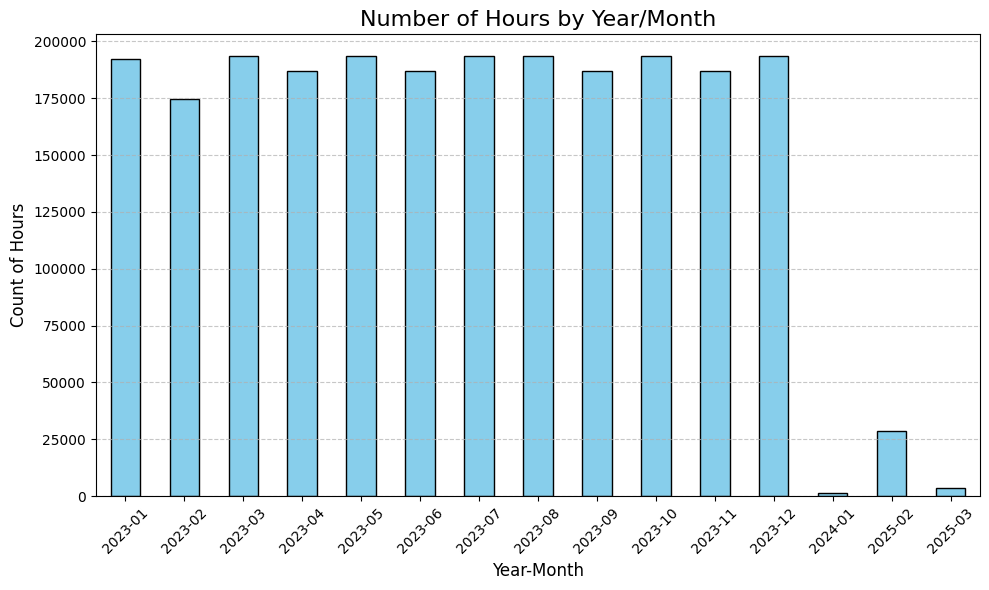

In [91]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [92]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 05:00:00,2,0,2023-01
1,2023-01-01 06:00:00,2,0,2023-01
2,2023-01-01 07:00:00,2,0,2023-01
3,2023-01-01 08:00:00,2,0,2023-01
4,2023-01-01 09:00:00,2,0,2023-01


In [95]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [96]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [97]:
filtered_data.shape

(2276300, 3)

In [98]:
ts_data = filtered_data

In [99]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2276300 entries, 0 to 2276299
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.7 MB


In [100]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T05:00:00.000000000', '2023-01-01T06:00:00.000000000',
       '2023-01-01T07:00:00.000000000', '2023-01-01T08:00:00.000000000',
       '2023-01-01T09:00:00.000000000'], dtype='datetime64[ns]')

In [101]:
ts_data

,pickup_hour,pickup_location_id,rides
0,2023-01-01 05:00:00,2,0
1,2023-01-01 06:00:00,2,0
2,2023-01-01 07:00:00,2,0
3,2023-01-01 08:00:00,2,0
4,2023-01-01 09:00:00,2,0
...,...,...,...
2276295,2023-12-31 19:00:00,263,92
2276296,2023-12-31 20:00:00,263,95
2276297,2023-12-31 21:00:00,263,87
2276298,2023-12-31 22:00:00,263,100


In [102]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [103]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 05:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 04:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 03:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 02:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-02 01:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 18:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 17:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 16:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 15:00:00,263


In [104]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 05:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 04:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 03:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 02:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-02 01:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 18:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 17:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 16:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 15:00:00,2


In [105]:
features_copy = features.copy()

In [106]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [107]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-03 20:25:04.797837')

In [108]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [109]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB


In [110]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [111]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x3144f1f80>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [112]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [113]:
predictions

array([ 0.15721424,  0.15721424,  0.15721424, ..., 84.70739334,
       79.45731942, 58.40239812])

In [114]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9225


In [116]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/NYC-Yellow-Taxi/models/lgb_model.pkl']

In [63]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [117]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/vedclove/Documents/Kaam-Dhanda/UniBuff/CDA500/NYC-Yellow-Taxi/models/lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/316663 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2049 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1215642/models/taxi_demand_predictor_next_hour/2


Model(name: 'taxi_demand_predictor_next_hour', version: 2)

In [118]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-03 20:26:17,584 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-03 20:26:17,598 INFO: Initializing external client
2025-03-03 20:26:17,598 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 20:26:18,259 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215642


In [119]:
from src.inference import get_model_predictions

In [120]:
preds = get_model_predictions(model, features_copy)

In [121]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,90.0
91516,263,91.0
91517,263,85.0
91518,263,79.0


In [122]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8286
